In [1]:
import torch
import torch.utils.data as da
import torch.nn as nn
import torch.optim as optim
import jieba
import argparse
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser()

parser.add_argument('--en_path', type=str, default='data/news-commentary-v13.zh-en.en',
                   help='英文数据集路径')
parser.add_argument('--zh_path', type=str, default='data/news-commentary-v13.zh-en.zh',
                   help='中文数据集路径')
parser.add_argument('--seq_len', type=int, default=20,
                   help='句子最大的长度，多则截断，少则补<unk>')
parser.add_argument('--pad', type=str, default='<unk>',
                   help='填充词')
parser.add_argument('--batch_size',type=int,default=32,
                   help='每轮批次')
parser.add_argument('--en_embedding_dim',type=int,default=256,
                   help='编码器词向量的长度')
parser.add_argument('--en_hidden_dim',type=int,default=512,
                   help='编码器深度')
parser.add_argument('--en_n_layers',type=int,default=2,
                   help='编码器LSTM的层数')
parser.add_argument('--de_embedding_dim',type=int,default=256,
                   help='解码器词向量的长度')
parser.add_argument('--de_hidden_dim',type=int,default=512,
                   help='解码器深度')
parser.add_argument('--de_n_layers',type=int,default=2,
                   help='解码器LSTM的层数')
parser.add_argument('--dropout',type=int,default=0.5,
                   help='droput')
parser.add_argument('--lr',type=int,default=0.0001,
                   help='学习率')
parser.add_argument('--weight_decay',type=int,default=0.1,
                   help='权重衰减/L2范式')
parser.add_argument('--clip',type=int,default=1,
                   help='梯度剪切')
parser.add_argument('--epochs',type=int,default=200,
                   help='训练轮数')
parser.add_argument('--attention',type=bool,default=False,
                   help='是否启用注意力机制')

#kwargs = parser.parse_args()
kwargs = parser.parse_known_args()[0]


In [4]:
# with open(kwargs.en_path, 'r') as f_en:
#     data_en = f_en.readlines()
# with open(kwargs.zh_path, 'r') as f_zh:
#     data_zh = f_zh.readlines()

In [5]:
#用一个小数据集合先玩玩
with open('./cmn-eng/cmn.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data = data.strip()
data = data.split('\n')
# 分割英文数据和中文数据
data_en = [line.split('\t')[0] for line in data]
data_zh = [line.split('\t')[1] for line in data]

In [6]:
#特殊处理
def data_process(text):
    text = text.lower()
    # 特殊数据处理，该地方可以各种替换缩略词等
    # 去除标点等
    return text

In [7]:
#对单句话进行分词
def get_token_text(text_en,text_zh):
    #简单的句子处理
    text_en=text_en.replace('.',' .').replace('?',' ?').replace('!',' !').replace(',',' , ')
    text_zh=text_zh.strip('\n')
    #英文以空格分割
    token_data_en = [data_process(st) for st in text_en.split()]
    #中文一般用jieba
    token_data_zh = [data_process(st) for st in jieba.cut(text_zh)]
    return [token_data_en,token_data_zh]

In [8]:
#对两个数据集的每句话进行分词
def get_token_data(data_en,data_zh):
    data_token_en = []
    data_token_zh = []
    for en,zh in zip(data_en,data_zh):
        en,zh=get_token_text(en,zh)
        data_token_en.append(en)
        data_token_zh.append(zh)
    return data_token_en,data_token_zh

In [9]:
def get_vocab(data):
    data=[j for i in data for j in i]
    top_1000 = Counter(data).most_common(100000)
    vocab = {x[0]:x[1] for x in top_1000}
    word_to_idx = {word: i + 4 for i, word in enumerate(vocab)}
    word_to_idx['<pad>'] = 0
    word_to_idx['<sos>'] = 1
    word_to_idx['<eos>'] = 2
    word_to_idx['<unk>'] = 3
    idx_to_word = {i + 4: word for i, word in enumerate(vocab)}
    idx_to_word[0] = '<pad>'
    idx_to_word[1] = '<sos>'
    idx_to_word[2] = '<eos>'
    idx_to_word[3] = '<unk>'
    vocab_size=len(idx_to_word)
    return vocab, vocab_size, word_to_idx, idx_to_word

In [10]:
# 填充和截断
def pad_st(features, maxlen, pad=0):
    padded_features = []
    for feature in features:
        feature.insert(0,'<sos>')
        feature.append('<eos>')
        if len(feature) > maxlen:
            padded_feature = feature[:maxlen]
            padded_feature[-1]='<eos>'#防止<eos>被切掉
        else:
            padded_feature = feature
            while (len(padded_feature) < maxlen):
                padded_feature.append(pad)
        padded_features.append(padded_feature)
    return padded_features

In [11]:
# 转化为索引
def encode_st(token_data, word_to_idx):
    features = []
    for sample in token_data:
        feature = []
        #feature.append(1)
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:#如果是词库中不存在的，认为是<unk>，即0
                feature.append(0)
        #feature.append(2)
        features.append(feature)
    
    return features

In [12]:
#此时为二维数组，每个数组是之前每句话的分词结果，词级别
en_data,zh_data=get_token_data(data_en,data_zh)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmpgoqxx3ux' -> '/tmp/jieba.cache'
Loading model cost 0.809 seconds.
Prefix dict has been built successfully.


In [13]:
print(en_data[0:2],zh_data[0:2])

[['hi', '.'], ['hi', '.']] [['嗨', '。'], ['你好', '。']]


In [14]:
vocab_en,vocab_size_en, word_to_idx_en, idx_to_word_en=get_vocab(en_data)
vocab_zh,vocab_size_zh, word_to_idx_zh, idx_to_word_zh=get_vocab(zh_data)


In [15]:
kwargs.vocab_size_en=vocab_size_en#记录vocab大小
kwargs.vocab_size_zh=vocab_size_zh#记录vocab大小
print(vocab_size_en,vocab_size_zh)

6904 14719


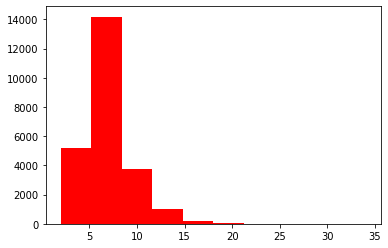

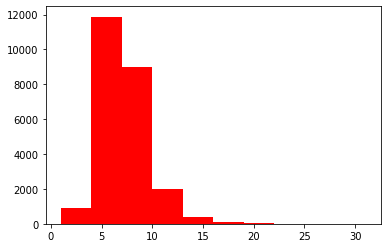

In [16]:
#看一下预料的长度分布，然后选择一个合适的seq_len
en_data_length=[]
for i in en_data:
    en_data_length.append(len(i))
n, bins, patches = plt.hist(en_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()
zh_data_length=[]
for i in zh_data:
    zh_data_length.append(len(i))
n, bins, patches = plt.hist(zh_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()

In [17]:
print(zh_data_length[0:10])

[2, 2, 5, 2, 3, 2, 2, 4, 3, 2]


In [18]:
en_data_id=encode_st(pad_st(en_data,kwargs.seq_len),word_to_idx_en)
zh_data_id=encode_st(pad_st(zh_data,kwargs.seq_len),word_to_idx_zh)

In [19]:
print(en_data_id[0:3])

[[1, 1766, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1766, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 534, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [20]:
en_data_id = torch.tensor(en_data_id)
zh_data_id = torch.tensor(zh_data_id)
en_data_length = torch.tensor(en_data_length)
zh_data_length = torch.tensor(zh_data_length)

In [21]:
# 数据集
train_set = torch.utils.data.TensorDataset(en_data_id, zh_data_id,en_data_length,zh_data_length)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=512,drop_last=True)

In [22]:
#开始模型部分
class Encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.input_dim = args.vocab_size_en
        self.emb_dim = args.en_embedding_dim
        self.hid_dim = args.en_hidden_dim
        self.n_layers = args.en_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.input_dim, self.emb_dim)   
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim, num_layers=self.n_layers,
                           dropout=self.dropout,bidirectional=True)

        
    def forward(self, x,input_lengths):
        embedded = (self.embedding(x))
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
        outputs, (hidden, cell) = self.rnn(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(sequence=outputs)
        return outputs,hidden, cell
class Decoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.emb_dim = args.de_embedding_dim
        self.hid_dim = args.de_hidden_dim
        self.output_dim = args.vocab_size_zh
        self.n_layers = args.de_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim,num_layers= self.n_layers,
                           dropout=self.dropout,bidirectional=True)
        bidirectional=True
        if bidirectional==True:
            self.out = nn.Linear(self.hid_dim*2, self.output_dim)
        else:
            self.out = nn.Linear(self.hid_dim, self.output_dim)
        self.dropout = nn.Dropout(self.dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden, cell):
        batch_size = x.size(0)
        embedded = self.dropout(self.embedding(x).view(1, batch_size, -1))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))       
        output = self.out(output.squeeze(0))
        prediction = self.softmax(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, args,device):
        super().__init__()
        self.attention=args.attention
        self.encoder = Encoder(args)
        if self.attention==True:
            self.decoder = DecoderAtten(args)
        else:
            self.decoder = Decoder(args)
        self.device = device
        self.seq_len=args.seq_len
        assert self.encoder.hid_dim == self.decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.encoder.n_layers == self.decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, src_length,trg_length,teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        max_target_length = self.seq_len
        outputs = torch.zeros(max_target_length, batch_size, trg_vocab_size).to(self.device)
        en_outputs,hidden, cell = self.encoder(src,src_length)   
        #输入到Decoder网络的第一个字符是<sos>（句子开始标记）
        de_input = trg[0]
        
        for t in range(max_target_length):
            #注意前面的hidden、cell和后面的是不同的
#             if self.attention==True:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell,en_outputs)
#             else:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell)
#             outputs[t] = output
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                    # decoder_output = [batch, output_dim]
                    # decoder_hidden = [n_layers*n_directions, batch, hid_dim]
                    output, hidden, cell = self.decoder(de_input, hidden, cell)
                    outputs[t] = output
                    output = trg[t]  # 下一个输入来自训练数据
            else:
                    output, decoder_hidden, cell = self.decoder(de_input, hidden, cell)
                    # [batch, 1]
                    topv, topi = output.topk(1)
                    outputs[t] = output
                    output = topi.squeeze(1)  # 
        return outputs

In [23]:
def train(args,device,model,train_iter):
    moedel=model.to(device)
    loss_function = nn.NLLLoss(ignore_index = 0)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    print("模型开始训练")
    for epoch in range(args.epochs):
        start = time.time()
        train_loss, train_acc = 0, 0
        n= 0
        model.train()
        for i,(input_batchs,target_batchs,input_lens,target_lens) in enumerate(tqdm(train_iter)):
            n += 1
            input_batchs = input_batchs.to(device).transpose(1,0)
            target_batchs = target_batchs.to(device).transpose(1,0)
            # list
            input_lens = input_lens.numpy()
            target_lens = target_lens.numpy()
            optimizer.zero_grad()
            output = model(input_batchs, target_batchs,input_lens,target_lens)
            loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()
            train_loss += loss
        end = time.time()
        runtime = end - start
        print(
            'epoch: %d, train loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,runtime)
        )

In [24]:
model=Seq2Seq(kwargs,device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6904, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(14719, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (out): Linear(in_features=1024, out_features=14719, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (softmax): LogSoftmax(dim=1)
  )
)


In [25]:
train(kwargs,device,model,train_iter)

  0%|          | 0/47 [00:00<?, ?it/s]

模型开始训练


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 0, train loss: 7.4107,time: 26.7417 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 1, train loss: 5.0399,time: 26.6395 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 2, train loss: 4.8451,time: 26.7006 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 3, train loss: 4.7461,time: 26.5513 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 4, train loss: 4.6470,time: 26.7356 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 5, train loss: 4.5632,time: 26.7696 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 6, train loss: 4.4822,time: 26.7360 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 7, train loss: 4.4139,time: 26.7123 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 8, train loss: 4.3490,time: 26.6895 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 9, train loss: 4.2938,time: 26.6866 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 10, train loss: 4.2325,time: 26.7037 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 11, train loss: 4.1683,time: 26.6412 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 12, train loss: 4.1113,time: 26.6977 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 13, train loss: 4.0551,time: 26.6662 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 14, train loss: 4.0083,time: 26.8668 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 15, train loss: 3.9483,time: 26.6996 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 16, train loss: 3.8977,time: 26.7361 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 17, train loss: 3.8418,time: 26.5601 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 18, train loss: 3.7877,time: 26.5900 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 19, train loss: 3.7352,time: 26.6291 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 20, train loss: 3.6806,time: 26.7372 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 21, train loss: 3.6298,time: 26.5236 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 22, train loss: 3.5791,time: 26.7545 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 23, train loss: 3.5376,time: 26.6352 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 24, train loss: 3.4940,time: 26.7512 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 25, train loss: 3.4565,time: 26.5155 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 26, train loss: 3.3974,time: 26.5664 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 27, train loss: 3.3626,time: 26.7395 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 28, train loss: 3.3268,time: 26.9721 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 29, train loss: 3.2693,time: 26.5962 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 30, train loss: 3.2169,time: 26.6856 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 31, train loss: 3.1752,time: 26.7351 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 32, train loss: 3.1309,time: 26.7299 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 33, train loss: 3.0905,time: 26.8274 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 34, train loss: 3.0428,time: 26.8453 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 35, train loss: 2.9843,time: 26.7131 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 36, train loss: 2.9398,time: 26.6769 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 37, train loss: 2.8948,time: 26.8471 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 38, train loss: 2.8611,time: 26.6499 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 39, train loss: 2.8160,time: 26.8070 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 40, train loss: 2.7773,time: 26.7848 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 41, train loss: 2.7358,time: 26.7172 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 42, train loss: 2.7138,time: 26.6867 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 43, train loss: 2.7044,time: 26.6496 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 44, train loss: 2.6701,time: 26.7503 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 45, train loss: 2.6430,time: 26.9141 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 46, train loss: 2.5859,time: 26.6510 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 47, train loss: 2.5391,time: 26.7954 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 48, train loss: 2.5136,time: 26.6968 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 49, train loss: 2.4833,time: 26.9372 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 50, train loss: 2.4514,time: 26.5885 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 51, train loss: 2.4360,time: 26.6984 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 52, train loss: 2.3840,time: 26.6291 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 53, train loss: 2.3428,time: 26.7682 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 54, train loss: 2.3251,time: 26.7645 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 55, train loss: 2.2826,time: 26.9509 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 56, train loss: 2.2501,time: 26.7340 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 57, train loss: 2.2181,time: 26.8314 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 58, train loss: 2.1880,time: 26.8219 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 59, train loss: 2.1625,time: 26.8972 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 60, train loss: 2.1304,time: 26.7036 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 61, train loss: 2.1782,time: 26.8000 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 62, train loss: 2.1270,time: 26.7091 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 63, train loss: 2.0616,time: 26.8317 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 64, train loss: 2.0661,time: 26.6035 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 65, train loss: 2.1101,time: 26.7504 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 66, train loss: 2.0870,time: 26.8364 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 67, train loss: 2.0606,time: 26.6881 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 68, train loss: 2.0136,time: 26.6908 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 69, train loss: 2.0009,time: 26.7798 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 70, train loss: 1.9667,time: 26.7071 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 71, train loss: 1.9876,time: 26.7267 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 72, train loss: 1.9658,time: 26.7670 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 73, train loss: 1.8876,time: 26.9246 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 74, train loss: 1.8450,time: 26.7317 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 75, train loss: 1.8099,time: 26.9109 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 76, train loss: 1.7728,time: 26.8275 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 77, train loss: 1.7408,time: 26.8232 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 78, train loss: 1.7297,time: 26.7987 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 79, train loss: 1.7177,time: 26.7677 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 80, train loss: 1.6792,time: 26.7127 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 81, train loss: 1.6808,time: 26.8199 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 82, train loss: 1.7400,time: 26.7992 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 83, train loss: 1.6901,time: 26.9309 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 84, train loss: 1.6374,time: 26.8217 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 85, train loss: 1.6257,time: 26.7182 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 86, train loss: 1.5840,time: 26.9918 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 87, train loss: 1.5626,time: 26.7686 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 88, train loss: 1.5617,time: 26.8859 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 89, train loss: 1.5370,time: 27.0562 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 90, train loss: 1.5681,time: 26.8711 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 91, train loss: 1.5156,time: 26.7302 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 92, train loss: 1.4964,time: 26.7748 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 93, train loss: 1.5703,time: 26.7230 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 94, train loss: 1.5684,time: 26.9020 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 95, train loss: 1.5300,time: 26.6488 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 96, train loss: 1.5114,time: 26.9322 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 97, train loss: 1.4521,time: 26.7986 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 98, train loss: 1.4030,time: 26.8657 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 99, train loss: 1.3972,time: 26.7747 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 100, train loss: 1.3531,time: 26.7288 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 101, train loss: 1.3554,time: 26.6291 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 102, train loss: 1.3516,time: 26.7453 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 103, train loss: 1.3995,time: 26.7908 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 104, train loss: 1.4236,time: 26.6993 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 105, train loss: 1.3442,time: 26.6253 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 106, train loss: 1.2918,time: 26.7555 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 107, train loss: 1.2521,time: 26.7009 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 108, train loss: 1.2283,time: 26.6267 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 109, train loss: 1.2199,time: 26.7193 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 110, train loss: 1.2233,time: 26.7463 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 111, train loss: 1.2022,time: 26.8660 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 112, train loss: 1.1926,time: 26.7418 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 113, train loss: 1.1641,time: 26.9156 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 114, train loss: 1.1532,time: 26.8366 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 115, train loss: 1.2196,time: 26.9482 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 116, train loss: 1.2225,time: 26.6493 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 117, train loss: 1.1578,time: 26.6791 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 118, train loss: 1.1208,time: 26.8359 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 119, train loss: 1.1245,time: 26.9133 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 120, train loss: 1.0965,time: 27.0625 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 121, train loss: 1.0978,time: 27.0321 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 122, train loss: 1.1193,time: 26.6319 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 123, train loss: 1.1502,time: 26.9436 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 124, train loss: 1.1715,time: 26.8765 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 125, train loss: 1.1952,time: 26.8794 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 126, train loss: 1.1806,time: 26.8296 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 127, train loss: 1.1655,time: 26.9095 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 128, train loss: 1.0530,time: 26.6454 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 129, train loss: 1.0346,time: 26.8590 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 130, train loss: 0.9972,time: 26.9253 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 131, train loss: 0.9941,time: 26.7930 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 132, train loss: 1.1718,time: 26.7885 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 133, train loss: 1.0762,time: 26.8657 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 134, train loss: 1.0614,time: 26.7367 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 135, train loss: 1.0658,time: 26.7644 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 136, train loss: 0.9667,time: 26.7937 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 137, train loss: 0.9493,time: 26.6957 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 138, train loss: 0.9952,time: 26.7705 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 139, train loss: 0.9117,time: 26.8050 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 140, train loss: 0.8830,time: 26.8045 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 141, train loss: 0.8983,time: 26.8869 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 142, train loss: 0.8774,time: 26.7830 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 143, train loss: 0.8524,time: 26.7826 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 144, train loss: 0.9240,time: 27.0047 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 145, train loss: 0.8847,time: 26.8575 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 146, train loss: 1.0010,time: 26.8322 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 147, train loss: 0.9516,time: 26.8091 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 148, train loss: 0.9443,time: 26.8452 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 149, train loss: 0.9392,time: 26.7056 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 150, train loss: 0.8309,time: 26.6115 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 151, train loss: 0.8948,time: 26.7770 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 152, train loss: 0.8597,time: 26.6766 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 153, train loss: 0.7749,time: 26.8160 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 154, train loss: 0.8818,time: 26.8608 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 155, train loss: 0.8940,time: 26.7648 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 156, train loss: 0.8796,time: 26.9127 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 157, train loss: 0.8169,time: 26.7471 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 158, train loss: 0.7528,time: 26.7284 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 159, train loss: 0.7342,time: 26.7329 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 160, train loss: 0.7427,time: 26.8713 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 161, train loss: 0.7017,time: 26.8775 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 162, train loss: 0.7151,time: 26.9002 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 163, train loss: 0.7642,time: 26.7617 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 164, train loss: 0.6884,time: 26.8395 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 165, train loss: 0.7237,time: 26.9763 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 166, train loss: 0.6696,time: 26.6601 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 167, train loss: 0.7066,time: 26.8333 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 168, train loss: 0.6624,time: 26.7328 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 169, train loss: 0.6251,time: 26.7908 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 170, train loss: 0.6232,time: 26.6724 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 171, train loss: 0.6149,time: 26.9662 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 172, train loss: 0.6513,time: 26.9335 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 173, train loss: 0.6067,time: 26.8935 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 174, train loss: 0.6852,time: 26.9017 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 175, train loss: 0.5845,time: 26.9319 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 176, train loss: 0.6129,time: 26.6384 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 177, train loss: 0.5689,time: 26.8291 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 178, train loss: 0.5670,time: 26.9662 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 179, train loss: 0.6335,time: 26.7016 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 180, train loss: 0.5968,time: 26.6221 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 181, train loss: 0.6596,time: 26.6873 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 182, train loss: 0.7296,time: 26.6759 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 183, train loss: 0.6591,time: 26.6878 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 184, train loss: 0.6294,time: 26.4918 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 185, train loss: 0.6387,time: 26.7681 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 186, train loss: 0.6997,time: 26.6467 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 187, train loss: 0.7271,time: 26.6524 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 188, train loss: 0.6055,time: 26.6273 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 189, train loss: 0.5412,time: 26.7151 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 190, train loss: 0.5225,time: 26.8890 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 191, train loss: 0.5353,time: 26.6009 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 192, train loss: 0.5223,time: 26.5712 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 193, train loss: 0.5378,time: 26.7258 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 194, train loss: 0.5473,time: 26.7030 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 195, train loss: 0.5506,time: 26.5954 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 196, train loss: 0.5198,time: 26.5976 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 197, train loss: 0.5351,time: 26.7059 



  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 198, train loss: 0.5233,time: 26.6144 



100%|██████████| 47/47 [00:26<00:00,  1.78it/s]

epoch: 199, train loss: 0.4990,time: 26.4329 



In [26]:
torch.save(model, 's2s_ci_small.pkl')

In [28]:

for i,(input_batchs,target_batchs,input_lens,target_lens) in enumerate(tqdm(train_iter)):
        n += 1
        input_batchs = input_batchs.to(device).transpose(1,0)
        target_batchs = target_batchs.to(device).transpose(1,0)
        output = model(input_batchs, target_batchs,input_lens,target_lens)
        if i==4:
            break
print(output.shape)
output=output.argmax(2)
print(output.shape)
print(input_batchs.shape)
input_batchs=input_batchs.transpose(1,0)
output=output.transpose(1,0)
target_batchs=target_batchs.transpose(1,0)
for z,i in enumerate(output):
    print('\n原文：')
    for j in input_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_en[j.item()],end=' ')
    print('\n正确答案：')
    for j in target_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')
    print('\n预测')
    for j in i:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')



  9%|▊         | 4/47 [00:01<00:16,  2.59it/s]


torch.Size([20, 512, 14719])
torch.Size([20, 512])
torch.Size([20, 512])

原文：
<sos> tom is my friend . 
正确答案：
<sos>湯姆是我的朋友。
预测
<sos>湯姆是我朋友。
原文：
<sos> tom is plastered . 
正确答案：
<sos>汤姆醉了。
预测
<sos>汤姆了。
原文：
<sos> tom is very kind . 
正确答案：
<sos>汤姆人很好。
预测
<sos>汤姆非常好。
原文：
<sos> tom isn't a fool . 
正确答案：
<sos>汤姆不是傻瓜。
预测
<sos>汤姆不是傻瓜
原文：
<sos> tom isn't a hero . 
正确答案：
<sos>湯姆不是英雄。
预测
<sos>汤姆不是英雄
原文：
<sos> tom isn't stupid . 
正确答案：
<sos>汤姆不傻。
预测
<sos>汤姆不傻。
原文：
<sos> tom likes cheese . 
正确答案：
<sos>汤姆喜欢芝士。
预测
<sos>汤姆喜欢芝士
原文：
<sos> tom likes it hot . 
正确答案：
<sos>汤姆喜欢热的。
预测
<sos>汤姆喜欢的。
原文：
<sos> tom lost his job . 
正确答案：
<sos>湯姆丟了工作。
预测
<sos>湯姆丟了工作。
原文：
<sos> tom saw the file . 
正确答案：
<sos>湯姆看了文件。
预测
<sos>湯姆看了。
原文：
<sos> tom studies hard . 
正确答案：
<sos>汤姆努力学习。
预测
<sos>汤姆努力学习。
原文：
<sos> tom walks slowly . 
正确答案：
<sos>汤姆走得很慢。
预测
<sos>汤姆走得很慢。
原文：
<sos> tom was captured . 
正确答案：
<sos>汤姆被囚禁了。
预测
<sos>汤姆被囚禁。
原文：
<sos> tom was mistaken . 
正确答案：
<sos>汤姆错了。
预测
<sos>汤姆错了。
原文：
<sos> tom will do that . 
正确答案：
<

<sos>他有些鋼筆。
预测
<sos>他有些鋼筆。
原文：
<sos> he has seven sons . 
正确答案：
<sos>他有七个儿子。
预测
<sos>他有七个。。
原文：
<sos> he has three sons . 
正确答案：
<sos>他有三个儿子。
预测
<sos>他有三个。。
原文：
<sos> he himself did it . 
正确答案：
<sos>是他自己做的。
预测
<sos>是自己自己的的
原文：
<sos> he is a screwball . 
正确答案：
<sos>他是一個怪人。
预测
<sos>他是一個。
原文：
<sos> he is an american . 
正确答案：
<sos>他是美国人。
预测
<sos>他是美国人。
原文：
<sos> he is at her side . 
正确答案：
<sos>他在她的旁邊。
预测
<sos>他在她旁邊。
原文：
<sos> he is but a child . 
正确答案：
<sos>他不过是个孩子。
预测
<sos>他不过个孩子。
原文：
<sos> he is from france . 
正确答案：
<sos>他是从法国来的。
预测
<sos>他是从法国来。
原文：
<sos> he is just my age . 
正确答案：
<sos>他和我同岁。
预测
<sos>他和我同岁。
原文：
<sos> he is watching tv . 
正确答案：
<sos>他在看电视。
预测
<sos>他在看电视。
原文：
<sos> he likes sleeping . 
正确答案：
<sos>他喜欢睡觉。
预测
<sos>他喜欢。。
原文：
<sos> he made me a suit . 
正确答案：
<sos>他给我做了套衣服。
预测
<sos>他给我了套衣服。
原文：
<sos> he struck a match . 
正确答案：
<sos>他劃了一根火柴。
预测
<sos>他劃了一根。
原文：
<sos> he studied abroad . 
正确答案：
<sos>他出国留学了。
预测
<sos>他出国了。
原文：
<sos> he talks too fast . 
正确答案：
<sos>他说话太快了。
预测
<sos>他说

<sos> is this your book ? 
正确答案：
<sos>這是你的書嗎？
预测
<sos>這是你的書？
原文：
<sos> it doesn't matter . 
正确答案：
<sos>没关系。
预测
<sos>没关系。
原文：
<sos> it is not a watch . 
正确答案：
<sos>這不是手錶。
预测
<sos>這不是手。
原文：
<sos> it is very simple . 
正确答案：
<sos>这很简单。
预测
<sos>这很。
原文：
<sos> it is windy today . 
正确答案：
<sos>今天有风。
预测
<sos>今天有风
原文：
<sos> it was our secret . 
正确答案：
<sos>它是我們的秘密。
预测
<sos>它是我們的秘密
原文：
<sos> it's a good start . 
正确答案：
<sos>这是一个好的开端。
预测
<sos>这是一个的的。
原文：
<sos> it's all my fault . 
正确答案：
<sos>都是我的错。
预测
<sos>都是的错错。
原文：
<sos> it's already 7:00 . 
正确答案：
<sos>已经是早上七点了。
预测
<sos>已经是七点了。
原文：
<sos> it's confidential . 
正确答案：
<sos>这是机密。
预测
<sos>这是机密。
原文：
<sos> it's hot out here . 
正确答案：
<sos>这里够热。
预测
<sos>这里够热。
原文：
<sos> it's human nature . 
正确答案：
<sos>它是人的天性。
预测
<sos>它是的天性。
原文：
<sos> it's my brother's . 
正确答案：
<sos>它是我兄弟的。
预测
<sos>它是我的。
原文：
<sos> it's not my fault . 
正确答案：
<sos>不是我的错。
预测
<sos>不是我的错。
原文：
<sos> it's not that far . 
正确答案：
<sos>不是那么远。
预测
<sos>不是那么远
原文：
<sos> it's on the house . 
正确答案：
<sos>这是免费的。

<sos>汤姆什么也没听见。
预测
<sos>汤姆什么什么听见。
原文：
<sos> tom helped us all . 
正确答案：
<sos>湯姆幫了我們。
预测
<sos>湯姆幫了。
原文：
<sos> tom is a good guy . 
正确答案：
<sos>tom是一個好人。
预测
<sos>tom是好人。
原文：
<sos> tom is a magician . 
正确答案：
<sos>汤姆是魔法师。
预测
<sos>汤姆是。
原文：
<sos> tom is a newcomer . 
正确答案：
<sos>汤姆是新来的。
预测
<sos>汤姆是新来。
原文：
<sos> tom is a true man . 
正确答案：
<sos>汤姆是个真男人。
预测
<sos>汤姆是个男人。
原文：
<sos> tom is happy here . 
正确答案：
<sos>湯姆在這裡很高興。
预测
<sos>湯姆在這裡高興。
原文：
<sos> tom is my brother . 
正确答案：
<sos>tom是我哥哥。
预测
<sos>tom是我哥哥。
原文：
<sos> tom is overweight . 
正确答案：
<sos>汤姆超重了。
预测
<sos>汤姆超重了
原文：
<sos> tom is testing me . 
正确答案：
<sos>汤姆在试探我。
预测
<sos>汤姆在我。
原文：
<sos> tom is very quiet . 
正确答案：
<sos>湯姆很安靜。
预测
<sos>湯姆很安靜。
原文：
<sos> tom isn't foolish . 
正确答案：
<sos>汤姆不傻。
预测
<sos>汤姆不。
原文：
<sos> tom isn't smiling . 
正确答案：
<sos>汤姆没在笑。
预测
<sos>汤姆没笑。
原文：
<sos> tom isn't unhappy . 
正确答案：
<sos>汤姆不是不高兴。
预测
<sos>汤姆不是不。
原文：
<sos> tom likes to knit . 
正确答案：
<sos>湯姆喜歡編織。
预测
<sos>湯姆喜歡編織
原文：
<sos> tom lit his cigar . 
正确答案：
<sos>湯姆點了雪茄。
预测
<sos